In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [2]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)
print("✅")

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.
✅


In [3]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


In [4]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


In [5]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


In [6]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

80142336/80134624 [==============================] - 1s 0us/step
EPOCH[1] - STEP[10] 
Generator_loss:0.0011 
Discriminator_loss:1.8190

EPOCH[1] - STEP[20] 
Generator_loss:0.0013 
Discriminator_loss:1.3091

EPOCH[1] - STEP[30] 
Generator_loss:0.0018 
Discriminator_loss:0.9636

EPOCH[1] - STEP[40] 
Generator_loss:0.0022 
Discriminator_loss:0.7844

EPOCH[1] - STEP[50] 
Generator_loss:0.0026 
Discriminator_loss:0.6855

EPOCH[1] - STEP[60] 
Generator_loss:0.0029 
Discriminator_loss:0.5805

EPOCH[1] - STEP[70] 
Generator_loss:0.0032 
Discriminator_loss:0.5046

EPOCH[1] - STEP[80] 
Generator_loss:0.0037 
Discriminator_loss:0.4453

EPOCH[1] - STEP[90] 
Generator_loss:0.0040 
Discriminator_loss:0.3974

EPOCH[1] - STEP[100] 
Generator_loss:0.0042 
Discriminator_loss:0.3583

EPOCH[1] - STEP[110] 
Generator_loss:0.0045 
Discriminator_loss:0.3263

EPOCH[1] - STEP[120] 
Generator_loss:0.0047 
Discriminator_loss:0.2995

EPOCH[1] - STEP[130] 
Generator_loss:0.0049 
Discriminator_loss:0.2768

EPOCH[1]

In [7]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [8]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


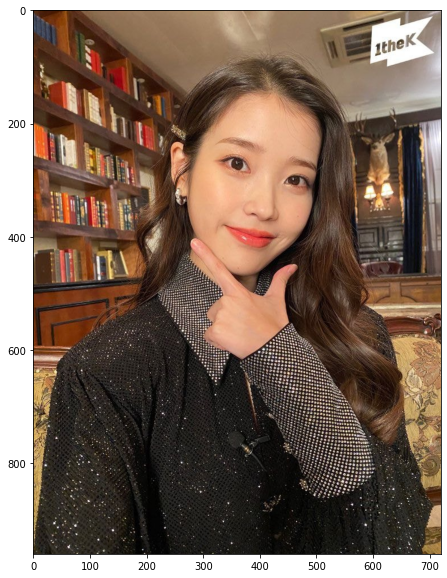

In [9]:
img_path = os.getenv('HOME')+'/aiffel/Exploration16/IU.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

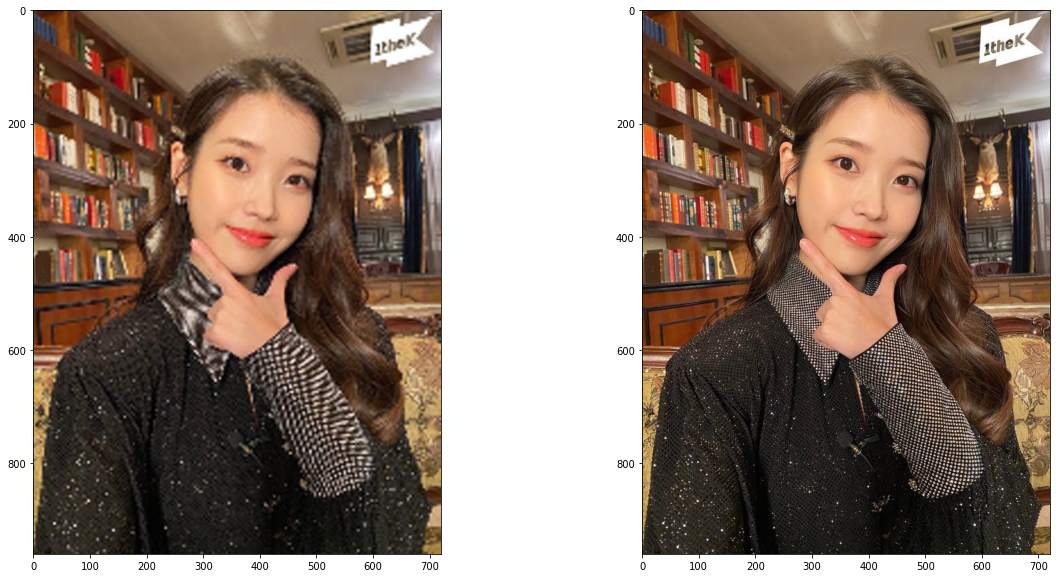

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

hr = img
lr = cv2.resize(img,dsize=(0,0),fx=0.25,fy=0.25,interpolation=cv2.INTER_LINEAR)
hr, lr = np.array(hr), np.array(lr)
srgan_hr = apply_srgan(lr)

bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

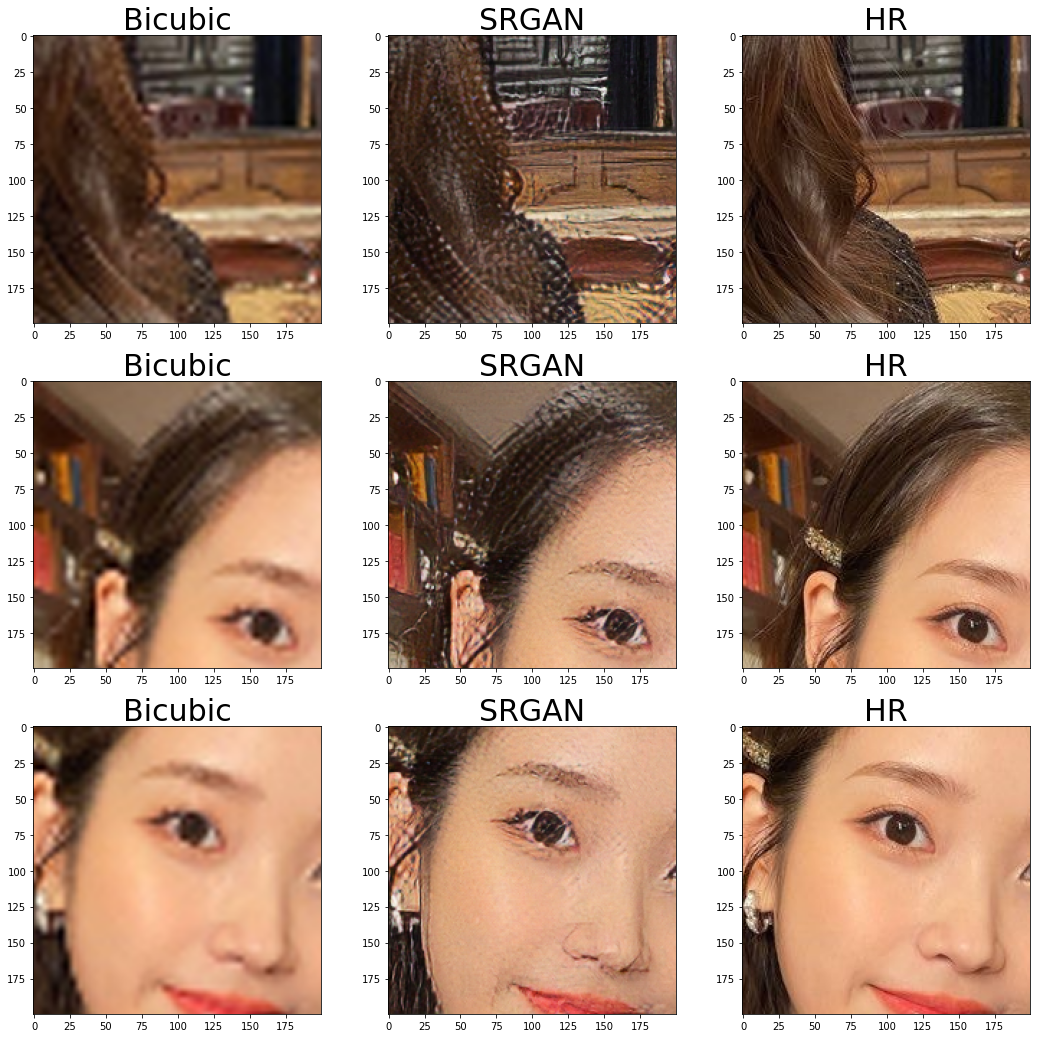

In [22]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (100,200), (200,250)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

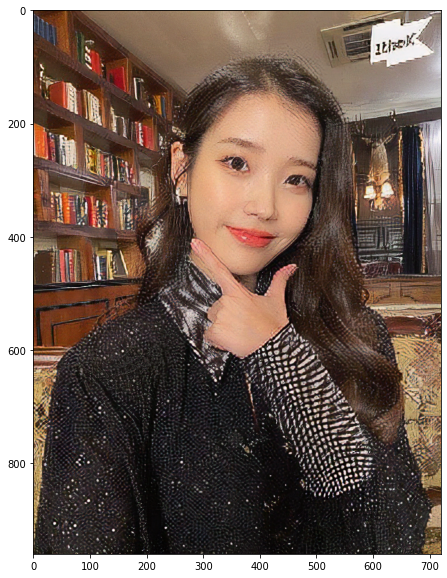

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(srgan_hr)

역시나 결과가 만족스럽지 못합니다.  
데이터셋이 특정한 이미지에만 특화되어 있어 제대로 이미지를 생성하지 못하는 것으로 보입니다.

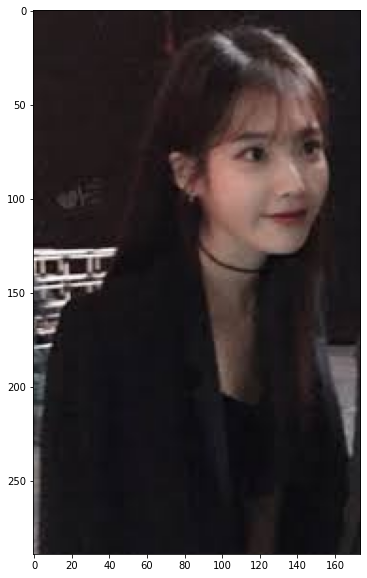

In [28]:
img_path = os.getenv('HOME')+'/aiffel/Exploration16/IU4.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

Text(0.5, 1.0, 'HR')

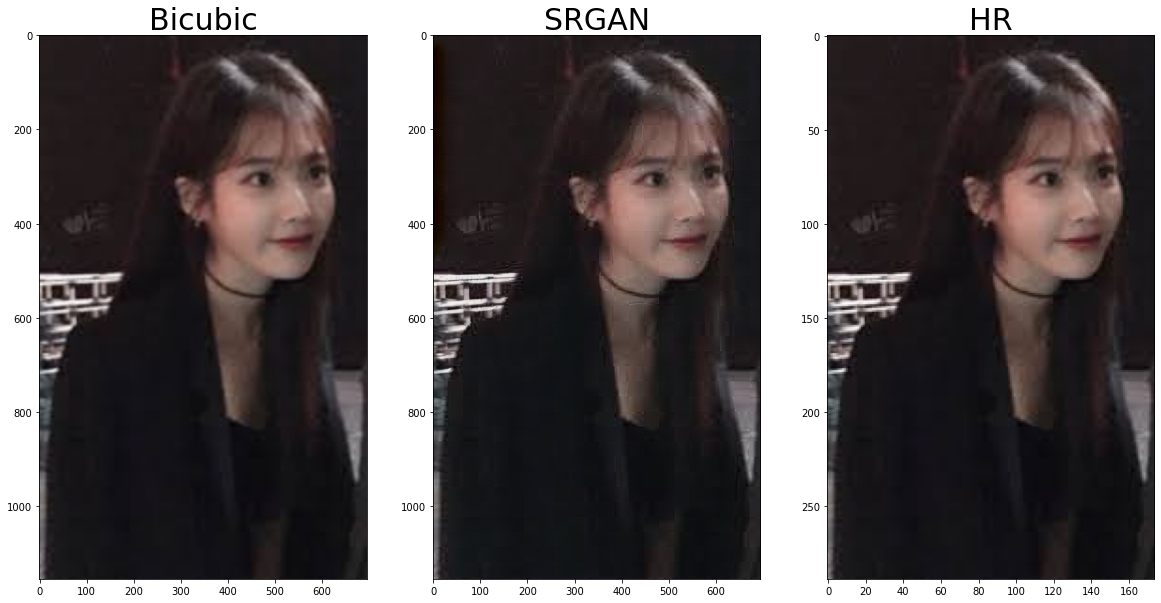

In [33]:
hr = img
lr = img
hr, lr = np.array(hr), np.array(lr)
srgan_hr = apply_srgan(hr) # 원본을 SRGAN에 넣기
bicubic_hr = cv2.resize(img,dsize=(0,0),fx=4.0,fy=4.0,interpolation=cv2.INTER_LINEAR)
#lr = cv2.resize(lr,dsize=(0,0),fx=4.0,fy=4.0,interpolation=cv2.INTER_LINEAR)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(bicubic_hr)
plt.title('Bicubic', fontsize=30)
plt.subplot(1,3,2); plt.imshow(srgan_hr)
plt.title('SRGAN', fontsize=30)
plt.subplot(1,3,3); plt.imshow(hr)
plt.title('HR', fontsize=30)

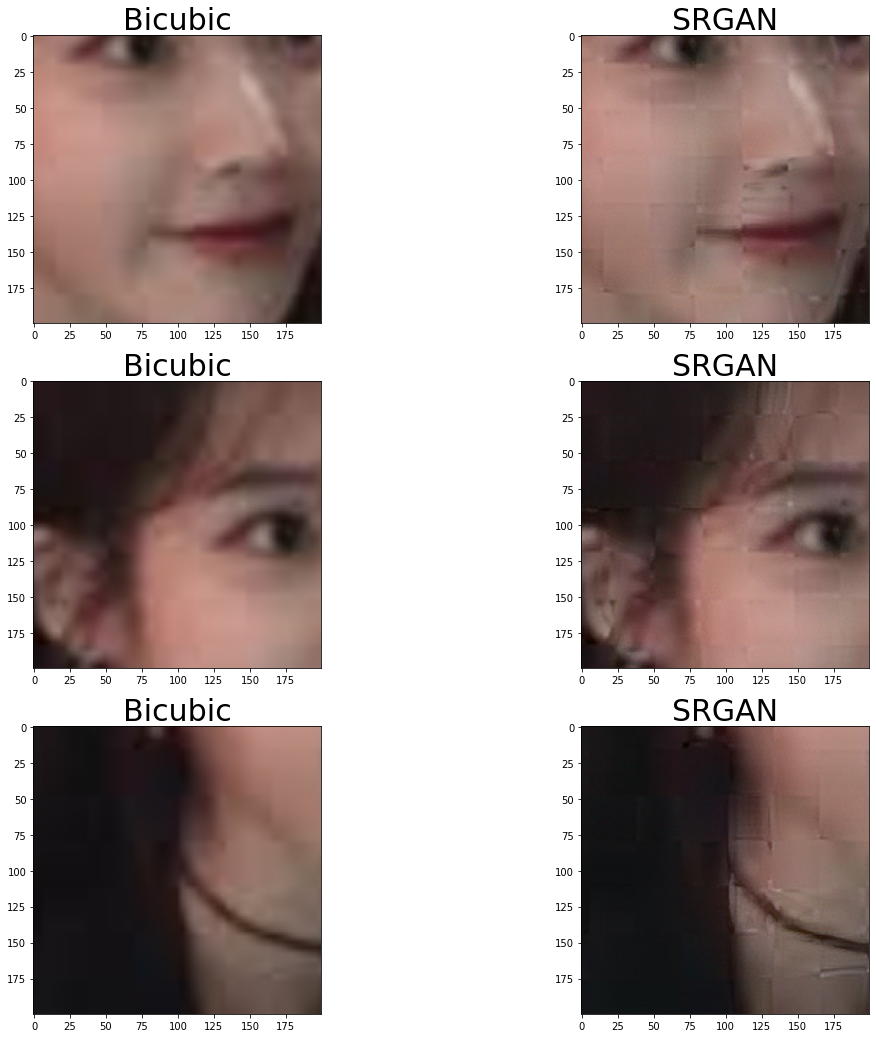

In [42]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(300,400), (200,300), (400,250)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

이번엔 SRGAN 이미지를 확대해보니 격자무늬가 확연하게 보입니다,  
왼쪽 Bicubic에도 격자무늬가 희미하게 보이는데 보간법 특성상 픽셀이 확대되면서 생긴 격자무늬를 SRGAN에서 패턴으로 인식해서 강조한 것 같습니다.

In [43]:
import cv2

img_path = os.getenv('HOME')+'/aiffel/Exploration16/wine_lr.gif'
gif = cv2.VideoCapture(img_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (340, 355, 3)


In [45]:
frams_sr_bic = []
frams_sr_srgan = []

for img in frames :
    hr = np.array(img)
    frams_sr_srgan.append(apply_srgan(hr))
    frams_sr_bic.append(cv2.resize(img,dsize=(0,0),fx=4.0,fy=4.0,interpolation=cv2.INTER_LINEAR))

In [47]:
import imageio

img_path = os.getenv('HOME')+'/aiffel/Exploration16/'
imageio.mimsave(img_path+"wine_sr_bicubic.gif", frams_sr_bic)
imageio.mimsave(img_path+"wine_sr_srgan.gif", frams_sr_srgan)

<img src="https://github.com/OverFlow37/images/blob/main/wine_lr.gif?raw=true" width = "800">

<img src="https://github.com/OverFlow37/images/blob/main/wine_sr_bicubic.gif?raw=true" width = "800">

<img src="https://github.com/OverFlow37/images/blob/main/wine_sr_srgan.gif?raw=true" width = "800">

gif파일을 슈퍼샘플링 해본 결과, 약간 아트스러운 느낌까지 나는 SRGAN에 손을 들어주고 싶습니다.  
데이터셋이 사물 위주로 학습해서 그런지 위의 아이유 사진과는 달리 매우 잘 적용된 모습입니다.